# Declaration

The following code implements and tests the Native Guide method to generate counterfactual explanations for ECG classification.
Native Guide was introduced by E. Delaney et al. in their paper "[Instance-based counterfactualexplanations  for  time  series  classification](https://arxiv.org/abs/2009.13211)". The Code for their implementation was provided in their [gitHub repository](https://github.com/e-delaney/Instance-Based_CFE_TSC), where we used some code for our implementation of Native Guide but incorporated extensive optimization, refactoring and additional functionalities.

To have an accurate deep learning CNN classifying complex ECG data, we reused the pretrained models from N. Strodthoff et al. in the paper "[Deep Learning for ECG Analysis: Benchmarks and Insights from PTB-XL](https://arxiv.org/abs/2004.13701)". Again we reused code from their [gitHub repository](https://github.com/helme/ecg_ptbxl_benchmarking) to use and test their model implementations coded with the pytorch library.

To implement the later synchronization algorithm, we were inspired by the code of L. Fridman et al. in the paper "[Automated synchronization of driving data using vibration and steering events](https://www.sciencedirect.com/science/article/abs/pii/S0167865516000581?via%3Dihub)" and blog entry "[Fast Cross Correlation and Time Series Synchronization in Python](https://lexfridman.com/fast-cross-correlation-and-time-series-synchronization-in-python/)"

Other code lines where based on own ideas and only used the official library documentations for implementation.

# Initialization - TYPE HERE!

Please provide an particular X_test_index and class_index! In case of None, a random index and class will be selected:
After running all cells, the counterfactual plot will be shown as the output in the end of the notebook and also saved in the [plot_counterfactuals](https://git.imp.fu-berlin.de/viktoa98/bachelor-thesis-about-counterfactuals-in-time-series-classification/-/tree/master/plot_counterfactuals) directory.

In [43]:
# Particular Index of X_test set to get a counterfactual for, if None random one is selected.
X_test_index = 23
# Only test samples from this class {0, 1, 2, 3, 4}, if None a random one is selected.
class_index = None

# Library and Utility Function import

In [44]:
from pytorch_models.code.utils import utils
from counterfactual_utils import *
from pytorch_models.code.models.fastai_model import fastai_model
import numpy as np
import torch
print(torch.__version__)
import tensorflow as tf
from tensorflow import keras
import time
from scipy.signal import find_peaks
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv1D, GlobalAveragePooling1D, BatchNormalization, Conv2D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import function
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from scipy.spatial.distance import cdist, pdist
from scipy import stats
from sklearn.neighbors import DistanceMetric
from tslearn.datasets import UCR_UEA_datasets
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout, InputLayer, LSTM, GRU, BatchNormalization, Bidirectional, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv1D, GlobalAveragePooling1D, BatchNormalization, Conv2D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import function
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn
from scipy.spatial.distance import cdist, pdist
from scipy import stats
from sklearn.neighbors import DistanceMetric
from tslearn.datasets import UCR_UEA_datasets
from tslearn.neighbors import KNeighborsTimeSeries
from sklearn.metrics import accuracy_score
from scipy.interpolate import interp1d
from sklearn.datasets import load_iris
from sklearn.manifold import MDS
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import LocalOutlierFactor
from tslearn.utils import to_sklearn_dataset
from sklearn.svm import OneClassSVM
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import os.path
from os import path
import wfdb
from numpy.fft import fft, ifft, fft2, ifft2, fftshift
import matplotlib.pyplot as pltnativeGuide
from pathlib import Path
import itertools
# Suppress deprecation messages.
tf.get_logger().setLevel(40)
# Disable TF2 behaviour as alibi code still relies on TF1 constructs.
tf.compat.v1.disable_v2_behavior()
%matplotlib inline
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly())

1.9.0+cu102
TF version:  2.3.0
Eager execution enabled:  False


# Pytorch CNN Models

In [45]:
def get_pytorch_model(modelname):
    """
    Load pytorch model from path ../pytorch_models/.
    Return pytorch and fastai models.
    Inspired by (N. Strodthoff et al., 2020).
    """
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":16:8"
    with torch.no_grad():
        torch.backends.cudnn.benchmark = False
        torch.use_deterministic_algorithms(True)
        # Path where the model is stored.
        pretrained_folder = f'pytorch_models/{modelname}/'
        # Path where the finetuned model will be stored.
        model_path = f'pytorch_models/{modelname}/'
        # Number of classes in dataset.
        n_classes_pretrained = 5

        model = fastai_model(
            modelname,
            num_classes,
            sampling_frequency,
            model_path,
            input_shape=input_shape,
            pretrainedfolder=pretrained_folder,
            n_classes_pretrained=n_classes_pretrained,
            pretrained=True,
            epochs_finetuning=2
        )
        X_dummy = [x.astype(np.float32) for x in X_test]
        y_dummy = [np.ones(num_classes, dtype=np.float32) for _ in range(len(X_test))]

        torchmodel = model._get_learner(X_dummy, y_dummy, X_dummy, y_dummy).model
        torchmodel.eval()
        return torchmodel, model


def get_feature_maps(model, X, layer_name):
    """Get the feature maps from the provided layer_name."""
    feature_maps = []

    def hook(model, input, output):
        feature_maps.append(output.detach())

    torch.device('cpu')
    for name, layer in model.named_modules():
        if layer_name == name:
            layer.register_forward_hook(hook)
    model(torch.from_numpy(X).float())
    return feature_maps[0].cpu().numpy()


def get_weights(torchmodel):
    """Get the weights from the last layer in torchmodel."""
    weights = torchmodel[-1][-1].weight.detach().cpu().numpy()
    return weights


def predict(fastaimodel, X):
    """Predict the data X the fastaimodel."""
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":16:8"
    return fastaimodel.predict(X)

# Data Preprocessing and Utility Functions


In [46]:
def load_datasets(path, load_validation_data=False):
    """Load training, testing and optionally validation data from given path."""
    X_train = np.load(Path(path) / "X_train.npy")
    y_train = np.load(Path(path) / "y_train.npy")
    X_test = np.load(Path(path) / "X_test.npy")
    y_test = np.load(Path(path) / "y_test.npy")
    if load_validation_data:
        X_val = np.load(Path(path) / "X_val.npy")
        y_val = np.load(Path(path) / "y_val.npy")
        return X_train, y_train, X_test, y_test, X_val, y_val
    else:
        return X_train, y_train, X_test, y_test


def normalize_dataset(X):
    """Normalize data so that minimum is at 0 and maximum at 1."""
    new_X = []
    for ts in X:
        ts_min = np.min(ts)
        ts_max = np.max(ts)
        new_X.append((ts - ts_min) / (ts_max - ts_min))
    new_X = np.array(new_X)
    return new_X


def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


def ptb_xl_labelname(y):
    """Get the real labelnames from numbers in y."""

    label_by_index = {
        0: "Conduction Disturbance",
        1: "Hypertrophy",
        2: "Myocardial Infarction",
        3: "Normal",
        4: "ST/T Change",
    }

    return [label_by_index[i] for i, prediction in enumerate(y) if prediction > 0.5]


def ucr_data_loader(dataset):
    """Load data for ucr datasets."""
    X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset(dataset)
    return X_train, y_train, X_test, y_test


def label_encoder(training_labels, testing_labels):
    """Encodes labels."""
    le = preprocessing.LabelEncoder()
    le.fit(np.concatenate((training_labels, testing_labels), axis=0))
    y_train = le.transform(training_labels)
    y_test = le.transform(testing_labels)
    return y_train, y_test


def numpy_delete_with_negative_indices(array, indices, axis):
    """
    Wrapper to do numpy delete with negative indices.
    The older version of numpy that is used by this environment cannot do that.
    """
    new_indices = indices[:]
    array_size = array.shape[0]
    for i in range(len(new_indices)):
        if new_indices[i] < 0:
            new_indices[i] += array_size
    return np.delete(array, new_indices, axis=axis)


def get_real_index_from_classlabel(y_test, test_ind, pred_class):
    """Get the real index from a index that was subsampled by a specific prediction class."""
    counter = 0
    real_ind = 0
    for y in y_test:
        if np.argmax(y) == pred_class:
            if counter == test_ind:
                print(f"Real index of {test_ind} is {real_ind}")
                break
            counter += 1
        real_ind += 1
    return real_ind

In [47]:
# # Test the real index of sample 2 in class 4
# X_train, y_train, X_test, y_test = load_datasets(path, load_validation_data=False)
# real_ind = get_real_index_from_classlabel(y_test, 2, 4)

The PTB-XL dataset is multilabeled, which means, that a sample can have multiple labels. However, that only makes sense, if a sample has multiple abnormal classes. Therefore we prove a function to clean the dataset form such samples:

In [48]:
def clean_ptbxl_multilabeled_dataset(X_train, y_train, X_test, y_test, X_val, y_val, num_classes, healthy_class):
    """
    Clean the dataset so that there is no sample that is assigned to a healthy and a abnormal class.
    Calling this function will save the training, validation and testing data in path data/cleaned_data.
    """
    classes = sum(itertools.chain(y_test, y_train, y_val), np.zeros(5))
    print("Number of samples in each class before clean: ", classes)
    
    all_y_data = np.concatenate((y_test, y_train), axis=0)
    all_y_data = np.concatenate((all_y_data, y_val), axis=0)
    print("Data Total: ", all_y_data.shape)

    multiple_labels_test = 0
    multiple_labels_train = 0 
    multiple_labels_val = 0 

    print("raw shapes:")
    print(y_test.shape)
    print(X_test.shape)
    print(y_train.shape)
    print(X_train.shape)
    print(y_val.shape)
    print(X_val.shape)

    multi_label_indices = []
    for ind, label in enumerate(y_test):
        ones = np.where(label == 1)[0]
        if ones.shape[0] > 1 and (healthy_class in ones):
            multiple_labels_test += 1
            multi_label_indices.append(ind)
    y_test = numpy_delete_with_negative_indices(y_test, multi_label_indices, 0)
    X_test = numpy_delete_with_negative_indices(X_test, multi_label_indices, 0)

    multi_label_indices = []
    for ind, label in enumerate(y_train):
        ones = np.where(label == 1)[0]
        if ones.shape[0] > 1 and (healthy_class in ones):
            multiple_labels_train += 1
            multi_label_indices.append(ind)
    y_train = numpy_delete_with_negative_indices(y_train, multi_label_indices, 0)
    X_train = numpy_delete_with_negative_indices(X_train, multi_label_indices, 0)

    multi_label_indices = []
    for ind, label in enumerate(y_val):
        ones = np.where(label == 1)[0]
        if ones.shape[0] > 1 and (healthy_class in ones):
            multiple_labels_val += 1
            multi_label_indices.append(ind)
    y_val = numpy_delete_with_negative_indices(y_val, multi_label_indices, 0)
    X_val = numpy_delete_with_negative_indices(X_val, multi_label_indices, 0)

    print("Deleted:")  
    print(multiple_labels_test)
    print(multiple_labels_train)
    print(multiple_labels_val)

    print("shapes after deletion:")
    print(y_test.shape)
    print(X_test.shape)
    print(y_train.shape)
    print(X_train.shape)
    print(y_val.shape)
    print(X_val.shape)

    # Get number of samples for each class.
    cleaned_classes = sum(itertools.chain(y_test, y_train, y_val), np.zeros(5))
    print("Number of samples in each class after clean: ", cleaned_classes)
    path = Path("Data") / "PTB-XL" / "cleaned_data"
    np.save(path / "X_test.npy", X_test)
    np.save(path / "X_train.npy", X_train)
    np.save(path / "X_val.npy", X_val)
    np.save(path / "y_test.npy", y_test)
    np.save(path / "y_train.npy", y_train)
    np.save(path / "y_val.npy", y_val)

PTB-XL is has too many data samples in the training set to have a reasonable runtime for the native guide finding algorithm, since every sample is a possible candidate. Therefore we randomly subsample the training data with equal amout of samples in each class too avoid imbalance.

In [49]:
def save_random_training_data(dataset_name, modelname, X_train, y_train, x_class_samples):
    """Save random samples equally from every class of the training data and save them normalized."""

    X_train = normalize_dataset(X_train)
    path = Path("Data") / dataset_name
    with torch.no_grad():
        # Get model.
        model, fastaimodel = get_pytorch_model(modelname)
        # Get predictions for training data.
        y_train_preds = predict(fastaimodel, X_train)
        for i in range(len(y_train_preds)):
            for y in range(5):
                if y_train_preds[i, y] > 0.5: 
                    y_train_preds[i, y] = 1
                else: 
                    y_train_preds[i, y] = 0

        # Select only data that where prediction and label is the same.
        good_indices = []
        for i in range(len(y_train)):
            if (y_train[i] == y_train_preds[i]).all():
                good_indices.append(i)
        good_indices = np.array(good_indices)
        good_indices = list(good_indices.flatten())
        good_X_train = X_train[good_indices]
        good_y_train = y_train[good_indices]
        good_y_train_preds = y_train_preds[good_indices]

        # Get random training data but with x_class_samples from each class for more balanced data.
        random_indices = []
        for i in range(5):
            train_indices = np.where(good_y_train_preds[:, i] == 1)[0]
            random_indices.extend(np.random.choice(train_indices, x_class_samples, replace=False))
        random_indices = np.array(random_indices)
        y_train_random = good_y_train[random_indices]
        X_train_random = good_X_train[random_indices, :, :]

        # Caution: Classes can still be slightly imbalances, because some samples are multilabeled.
        classes = sum(itertools.chain(y_train_random, np.zeros(5)))
        print("Number of samples in each class before clean: ", classes)
        # Save the randomly selected data.
        np.save(path / "random_data" / f"y_train_random{len(random_indices)}.npy", y_train_random)
        np.save(path / "random_data" / f"X_train_random{len(random_indices)}.npy", X_train_random)

        return X_train_random, y_train_random

In [50]:
# # Get data for PTB-XL.
# dataset_name = "PTB-XL"
# path = Path("Data") / "PTB-XL" / "cleaned_data"
# X_train, y_train, X_test, y_test, X_val, y_val = load_datasets(path, load_validation_data=True)
# modelname = "fastai_fcn_wang"
# save_random_training_data(dataset_name, modelname, X_train, y_train, 200)

# Native Guide

## Classic Implementations

In [51]:
def dtw_plotting(query: np.ndarray, guide: np.ndarray, qindex: int, 
                 gindex: int, save_warp: bool = False):
    """Plot an dtw graph of 2 time series."""
    path = dtw.warping_path(query, guide)
    distance = dtw.distance(query, guide)
    dtwvis.plot_warping(query, guide, path) 
    if save_warp:
        filename = f"{dataset}_test{qindex}_guide{gindex}_warp.png"


def native_guide_retrieval(X_train, y_train, index, query, y_train_preds, y_ng_labels, y_test_preds, y_test_labels,
                           distance, k, healthy_class, boundary, save_dtwplot=False):
    """Finds the k nearest neighbours for a query time series, that is in another class."""
    ts_length = X_train.shape[1]
    leads = X_train.shape[2]

    # Unsupervised learner for implementing neighbor searches for Time Series.
    knn = KNeighborsTimeSeries(n_neighbors=k, metric=distance) 

    # Use only training data that is in the other class.
    healthy_indices = []
    sick_indices = []
    for i in range(len(y_ng_labels)):
        if (y_train_preds[i][np.argwhere(y_test_labels == 1)] < boundary).all():
            if y_ng_labels[i, healthy_class] == 1:
                healthy_indices.append(i)
            else:
                sick_indices.append(i)
    if y_test_labels[healthy_class] == 1:
        native_guides = np.copy(X_train[sick_indices])
    else:
        native_guides = np.copy(X_train[healthy_indices])
    knn.fit(native_guides)

    # Finds the K-neighbors of a point. 
    # Returns indices of and distances to the neighbors of each point as arrays.
    dist, ind = knn.kneighbors(query.reshape(1, ts_length, leads), return_distance=True) 
    
    # Return first distance and indices of nearest neighbour with class change.
    if y_test_labels[healthy_class] == 1:
        native_guides = [sick_indices[ind[0][0]]]
    else: 
        native_guides = [healthy_indices[ind[0][0]]]
    native_guides = np.array(native_guides)

    if save_dtwplot:
        for guide in native_guides:
            dtw_plotting(np.reshape(query, query.shape[0]), np.reshape(X_train[guide], 
                                    X_train[guide].shape[0]), index, guide)
    
    return dist[0], native_guides


def find_subarray(weight_array, subarray_length): 
    """Used to find the maximum contiguous subarray with subarray_length in the explanation weight vector."""
    cumulative_weights = [0]
    for weight in weight_array:
        cumulative_weights.append(weight + cumulative_weights[-1])

    possible_subarray_count = len(weight_array) - subarray_length + 1

    all_sum_weights = []
    for start in range(possible_subarray_count):
        all_sum_weights.append(cumulative_weights[start + subarray_length] - cumulative_weights[start])
    starting_point = np.argmax(all_sum_weights)

    return starting_point


def smooth_neighbour_distances(X_test, instance, native_guide, generated_cf, array_length, leads):
    """Smooth difference between two high jumps in the counterfactual."""
    cf_maxdiff = neighbour_diff(generated_cf.reshape(1, array_length, leads), leads)
    test_maxdiff = neighbour_diff(X_test[instance].reshape(1, array_length, leads), leads)
    nun_maxdiff = neighbour_diff(native_guide[0].reshape(1, array_length, leads), leads)
    diff_boundary = max([test_maxdiff, nun_maxdiff])
    if cf_maxdiff > diff_boundary:
        generated_cf = reduce_diff(generated_cf.reshape(array_length, leads), leads, diff_boundary)
    return generated_cf


def test_subarray_length(subarray_length, X_test, native_guide, y_test_label_instances, instance, leads, array_length):
    """Produce a counterfactual for a given subarray length and test whether it is in a new class."""
    # Find most infuencial subarray for a time series in training data & it's starting point.
    starting_point = find_subarray((native_guides_weights), subarray_length)
    # Start generating the counterfactual by perturbating (replacing query subsequence by native guide subsequence).
    generated_cf = np.concatenate((X_test[instance][:starting_point], native_guide[0][starting_point:subarray_length+starting_point], X_test[instance][subarray_length+starting_point:]), axis=0)
    # Get the probability to be in the same class as instance -> goal is less then 0.5, so that other class is label.
    prob_targets = np.array(predict(fastaimodel, generated_cf.reshape(1, -1, leads))[0][y_test_label_instances])
    generated_cf = smooth_neighbour_distances(X_test, instance, native_guide, generated_cf, array_length, leads)

    return generated_cf, prob_targets


def counterfactual_generator_swap(X_test, X_test_index, native_guide, native_guides_weights, instance, nun, 
                                  subarray_length, array_length, leads, boundary=0.5):
    """Generate the counterfactual for a given query time series."""
    X_test = X_test.reshape(1, array_length, leads)
    native_guide = native_guide.reshape(1, array_length, leads)

    # Get predicted values for data.
    y_test_preds = predict(fastaimodel, X_test)
    y_test_label_instances = []
    for y in range(len(y_test_preds[0])):
        if y_test_preds[0][y] > 0.5: 
            y_test_label_instances.append(y)

    # As long as generated Counterfactual is still in query class.
    while True: 
        subarray_length += 10
        generated_cf, prob_targets = test_subarray_length(subarray_length, X_test, native_guide, 
                                                          y_test_label_instances, instance, 
                                                          leads, array_length)
        is_valid_counterfactual = (prob_targets < boundary).all() 
        if is_valid_counterfactual:
            break
      
    print("Boundary: ", boundary)
    print("Old confidence: ",  prob_targets)
    print("Subarray_length: ", subarray_length)
    return generated_cf, subarray_length, prob_targets

## Additional optimization functions

In [52]:
def cross_correlation_using_fft(x, y):
    """
    Compute the cross correlation between x and y using fft.
    Inspired by (L. Fridman et al., 2016).
    """
    f1 = fft(x)
    f2 = fft(np.flipud(y))
    cc = np.real(ifft(f1 * f2))
    return fftshift(cc)


def compute_shift(x, y):
    """
    Compute for how much we need to shift y to align the signals.
    Inspired by (L. Fridman et al., 2016).
    """
    assert len(x) == len(y)
    c = cross_correlation_using_fft(x, y)
    assert len(c) == len(x)
    zero_index = int(len(x) / 2) - 1
    # shift < 0 means that y starts 'shift' time steps before x 
    # shift > 0 means that y starts 'shift' time steps after x.
    shift = zero_index - np.argmax(c)
    return shift


def apply_shift(x, y, shift):
    """Apply the shift on the signals."""
    shift = abs(shift)
    return x[shift:], y[:-shift]


def synchronize_series(ts1, ts2, leads, origin_len, len_for_sync=100, show=False):
    """Synchronize ts1 and ts2 by shifting."""
    # Get one lead with 'len_for_sync' data points for synchronization.
    len_for_sync = int(len_for_sync)
    ts1lead = ts1[:len_for_sync, 0]
    ts2lead = ts2[:len_for_sync, 0]

    deleted_ts1 = ts1
    deleted_ts2 = ts2
    shift = compute_shift(ts1lead, ts2lead)
    if shift == 0:
        # No synchronization needed.
        deleted_ts1 = ts1
        deleted_ts2 = ts2
    elif shift < 0: 
        # Synchronize by shifting ts1.
        deleted_ts1, deleted_ts2 = apply_shift(ts1, ts2, shift)
    else:
        # Synchronize by shifting ts2.
        deleted_ts2, deleted_ts1 = apply_shift(ts2, ts1, shift)
    return deleted_ts1, deleted_ts2, origin_len - abs(shift)


def neighbour_diff(X, leads):
    """Get the max difference between two neighbouring elements."""
    differences = []
    for x in X:
        for lead in range(leads):
            differences.append(np.max(np.absolute(np.diff(x[:, lead]))))
    maxdiff = np.max(np.array(differences))
    return maxdiff


def reduce_diff(X, leads, diff_boundary):
    """Reduce the difference between two neighboring points."""
    for lead in range(leads):
        while np.max(np.absolute(np.diff(X[:, lead]))) > diff_boundary:
            X_diffs = np.diff(X[:, lead])
            maxdiff_arg = np.argmax(np.absolute(X_diffs))
            X[maxdiff_arg + 1, lead] = X[maxdiff_arg + 1, lead] - X_diffs[maxdiff_arg] / 4
    return X


def swap_point_for_point(X_test, X_test_index, native_guide, native_guides_weights, 
                         instance, nun, subarray_length, array_length, leads, boundary=0.5):
    X_test = X_test.reshape(1, array_length, leads)
    # Make all weights positive.
    native_guides_weights = np.array(native_guides_weights) + abs(np.min(np.array(native_guides_weights)))
    featureList = []

    # Get predicted values for data.
    y_test_preds = predict(fastaimodel, X_test)
    y_test_label_instances = []
    for y in range(len(y_test_preds[0])):
        if y_test_preds[0][y] > 0.5: 
            y_test_label_instances.append(y)
    weightlist = native_guides_weights
    generated_cf = np.copy(X_test[0].reshape(array_length, leads))
    # This should also be a do-while loop. The code above looks like the code in the loop.
    # As long as generated Counterfactual is still in query class.
    while True: 
        # Get the highest weight and make it negative to not use it anymore.
        featureIndex = np.argmax(weightlist)
        featureList.append(featureIndex)
        weightlist[featureIndex] = -1000
        # Continue generating the counterfactual by perturbating (replacing query point by native guide point).
        generated_cf.reshape(array_length, leads)[featureIndex] = native_guide[0].reshape(array_length, leads)[featureIndex]
        # Get the probability to be in the same class as instance -> goal is less then 0.5, so that other class is label.
        prob_targets = np.array(predict(fastaimodel, generated_cf.reshape(1, array_length, leads))[0][y_test_label_instances])
        # Smooth difference between to high jumps in counterfactual.
        generated_cf = smooth_neighbour_distances(X_test, instance, native_guide, generated_cf, array_length, leads)
        # Check whether the counterfactual is valid and break loop if it is.
        is_valid_counterfactual = (prob_targets < boundary).all() 
        if is_valid_counterfactual:
            break
        # Increase subarray length because counterfactual is not valid yet.
        subarray_length += 1
    print("Boundary: ", boundary)
    print("Old confidence: ",  prob_targets)
    print("Subarray_length: ", subarray_length)
    generated_cf = generated_cf.reshape(array_length, leads)
    return generated_cf, subarray_length, (np.mean(prob_targets))

In [53]:
def get_median_ECG_wavelength(ts, origin_len):
    """Get the median wavelength over all leads of an ECG time series."""
    wavelengths_small = []
    wavelengths_big = []
    wavelengths = []
    for lead in range(leads):
        # Find peaks and wavelength for ts.
        ts_norm = normalize_dataset(ts[:, lead].reshape(1, origin_len))
        one_lead = (ts_norm.reshape(origin_len)).astype(float)
        # In case peaks are very big.
        peaks_big = find_peaks(one_lead, height=0.2, width=10, 
                               threshold=np.mean(one_lead) * 0.001, prominence=0.5)
        # In case peaks are very small.
        peaks_small = find_peaks(one_lead, height=0.2, width=10, 
                                 threshold=np.mean(one_lead) * 0.001, prominence=0.2)
        peaks_positions_small = peaks_small[0]
        peaks_positions_big = peaks_big[0]
        for y in range(len(peaks_positions_small) - 1):
            wavelengths_small.append(peaks_positions_small[y + 1] - peaks_positions_small[y])
        for y in range(len(peaks_positions_big)-1):
            wavelengths_big.append((peaks_positions_big[y + 1] - peaks_positions_big[y]))
        # Take the one that is closer to average wavelength of 80.
        if abs(80 - np.median(wavelengths_small)) > abs(80 - np.median(wavelengths_big)):
            wavelengths = wavelengths_big
        else:
            wavelengths = wavelengths_small
    median_wavelength = np.nanmedian(wavelengths)
    return median_wavelength


def wavelength_sync(ts_stay, ts_change, leads, origin_len):
    """Synchronize two ECG time series wavelength."""
    new_ts_stay = []
    new_ts_change = []
    median_wavelength_stay = get_median_ECG_wavelength(ts_stay, origin_len)
    median_wavelength_change = get_median_ECG_wavelength(ts_change, origin_len)
    # How much ts_change needs to be subsampled to get same wavelength.
    t = median_wavelength_change / median_wavelength_stay
    changed_indices = []
    if t == 1:
        # Wavelengths already the same.
        new_ts_stay = ts_stay
        new_ts_change = ts_change
        changed_indices = np.arange(len(ts_change))
        new_len = len(new_ts_change)
    else:
        for i in range(int(round(len(ts_change) / t))):
            # Subsample ts_change points to get same wavelength.
            changed_indices.append(int(i * t))
            new_ts_change.append(ts_change[int(i * t)])
        new_ts_change = np.array(new_ts_change)
        new_len = len(new_ts_change)
        if new_len <= origin_len:
            # If subsampling decreased array length, cut off difference at the end of ts_stay.
            deletePoints = np.negative(np.array(range(1, origin_len-new_len + 1)))
            new_ts_stay = numpy_delete_with_negative_indices(ts_stay, deletePoints, axis=0)
            new_ts_stay = np.array(new_ts_stay)
        else:
            # If subsampling increased array length, cut off difference at the end of ts_change.
            deletePoints = np.negative(np.array(range(1, new_len-origin_len + 1)))
            new_ts_change = numpy_delete_with_negative_indices(new_ts_change, deletePoints, axis=0)
            new_ts_change = np.array(new_ts_change)
            new_ts_stay = ts_stay
    new_len = len(new_ts_change)
    return new_ts_stay, new_ts_change, new_len, median_wavelength_stay, changed_indices

# Weights for Class Activation Mapping

In [54]:
def get_cam_weights(ts, y_ts, origin_len, leads, modelname, featuremap_layer, predicted, pred_labels):
    """
    Gets the importance values for every time series data point to do a cam. 
    It uses the weights from the last dense layer and the last feature maps 
    after convolution to assign an importance score for each point in the time series.
    Modelname and corresponding featuremap_layer needs to be provided.
    Inspired by (E. Delaney et al., 2021).
    """
    torch.manual_seed(0)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":16:8" 
    with torch.no_grad():
        torch.backends.cudnn.benchmark = False
        torch.use_deterministic_algorithms(True)
        max_length = origin_len
        model, fastaimodel = get_pytorch_model(modelname)
        model.eval()
        
        # Weights for each filter k for each class c from last layer (Softmax-Layer), 
        # returns the kernel matrix and the bias vector.
        # The Dense layer is a subclass of Layer and its weights, 
        # which is a type of python list has two elements weight of the layer stored 
        # at layer.get_weights()[0].
        # The bias is stored at layer.get_weights()[1].
        w_k_c = get_weights(model)
        y_cam = np.argmax(y_ts)

        cam_weights = []
        ts = ts.reshape(1, leads, origin_len)
        # conv_output is output of final_conv_layer.
        conv_out = get_feature_maps(model, ts, featuremap_layer)
        ts = ts.reshape(1, origin_len, leads)
        missing_len = origin_len - conv_out.shape[2]
        # Insert zeros if feature maps have less data points because of padding.
        # This is not the case for fcn.
        for _ in range(missing_len):
            conv_out = np.insert(conv_out, -1, 0, axis=2)
        conv_out = conv_out.reshape(1, origin_len, 128)
        ts = ts.reshape(1, origin_len, leads)
        cas = np.zeros(dtype=np.float, shape=conv_out.shape[1])
        # k as counter and w as value in w_k_c, loop over weights that are same as label.
        for y in pred_labels:
            for k, w in enumerate(w_k_c[:, y]):
                # cas is array that containes the importance values to each time series point.
                cas += w * conv_out[0, :, k]
        cam_weights = cas
        cam_weights = np.array(cam_weights)
        
        return cam_weights

# Tests for Investigation of Native Guide

## Test which percentage of the testing data predictions are changed through synchronization
To start test, please just call: evaluate_sync_change()

Note: This test could take several hours!

In [55]:
def evaluate_sync_change():
    dataset = "PTB-XL"
    path = Path("Data") / "PTB-XL" / "cleaned_data"
    X_train, y_train, X_test, y_test, X_val, y_val = load_datasets(path, load_validation_data=True)
    # Get the random 1000 samples from training set as native guide candidates.
    X_train = np.load(Path("Data") / f"{dataset}" / "random_data" / "X_train_random1000.npy")
    y_train = np.load(Path("Data") / f"{dataset}" / "random_data" / "y_train_random1000.npy")
    X_test = normalize_dataset(X_test)
    X_train = normalize_dataset(X_train)
    X_val = normalize_dataset(X_val)

    origin_len = 1000
    modelname = "fastai_fcn_wang"
    changed_counter = 0
    y_train_preds = predict(fastaimodel, X_train)
    y_ng_labels = np.copy(y_train_preds)
    for y in range(len(y_ng_labels)):
      for i in range(len(y_ng_labels[y])):
          if y_ng_labels[y, i] > 0.5: 
              y_ng_labels[y, i] = 1
          else: 
              y_ng_labels[y, i] = 0
    y_ng_labels = y_ng_labels.astype(int)
    for ind, x in enumerate(X_test):
        x = x.reshape(1,origin_len,leads)
        y = y_test[ind].reshape(1,5)
        is_changed = test_sync_predchange(x, y, X_train, y_train, y_train_preds, y_ng_labels, origin_len, leads, modelname)
        if is_changed:
            changed_counter += 1
        perc_changed = changed_counter / (ind + 1)
        print(f"{ind+1}/{len(X_test)}")
        print("Percentage of sync time series with prediction change: ", perc_changed)


def test_sync_predchange(X_test, y_test, X_train, y_train, y_train_preds, y_ng_labels, origin_len, leads, modelname):
  """Test for all X_test data how many synchronizations change the prediction."""
  # Get the model.
  model, fastaimodel = get_pytorch_model(modelname)
  torchmodel = model
  # Get predicted values for data.
  y_test_preds = predict(fastaimodel, X_test)[0]
  y_test_labels = np.copy(y_test_preds)
  for y in range(len(y_test_labels)):
      if y_test_labels[y] > 0.5:
          y_test_labels[y] = 1
      else: 
          y_test_labels[y] = 0
  y_test_labels = y_test_labels.astype(int)

  # Get the native guide from the training set.
  nuns = []
  dists = []
  instance = 0
  out_dist, out_nuns = native_guide_retrieval(X_train, y_train, instance, X_test[instance], 
                                              y_train_preds, y_ng_labels, y_test_preds, y_test_labels,
                                              'dtw', 1, 3, boundary,
                                              save_dtwplot = False)
  nun = out_nuns[0]
  X_native_guide = X_train[nun]
  y_native_guide = y_train[nun]

  # Synchronization of the query and native guide.
  old_native_guide = X_native_guide
  ts1, ts2, new_len = synchronize_series(X_test[0].reshape(1000, 12),
                                        X_native_guide.reshape(1000, 12),
                                        12, 1000, show=True)
  new_ts_stay, new_ts_change, new_len, median_wavelength_stay, changed_indices = wavelength_sync(ts1, ts2, 12, new_len)
  new_ts_stay, new_ts_change, new_len = synchronize_series(new_ts_stay.reshape(len(new_ts_stay), 12),
                                                          new_ts_change.reshape(len(new_ts_change), 12), 
                                                          12, new_len, median_wavelength_stay, True)

  assert(new_len == len(new_ts_stay))
  assert(new_len == len(new_ts_change))
  X_test = new_ts_stay.reshape(1, len(new_ts_stay), 12)
  X_native_guide = new_ts_change.reshape(1, len(new_ts_change), 12)

  # Predict new synchronized native guide.
  pred_old_native_guide = predict(fastaimodel, old_native_guide.reshape(1, 1000, 12))[0]
  pred_native_guide = predict(fastaimodel, X_native_guide)[0]
  pred_labels_native_guide = np.copy(pred_native_guide)
  for y in range(len(pred_labels_native_guide)):
      if pred_labels_native_guide[y] > 0.5:
          pred_labels_native_guide[y] = 1
      else:
          pred_labels_native_guide[y] = 0
  pred_labels_native_guide = pred_labels_native_guide.astype(int)

  old_max_pred = np.argmax(predict(fastaimodel, old_native_guide.reshape(1, 1000, 12)), axis=1)
  new_max_pred = np.argmax(predict(fastaimodel, X_native_guide), axis=1)
  is_changed = old_max_pred != new_max_pred
  return is_changed

In [56]:
# evaluate_sync_change()

## Test different decision boundaries and plot/save results
To start test, please just call: call_decision_boundary_shifting()

Note: if you updated the random training subset, selected samples might not work anymore. 
In that case you have to determine first which samples are executable with a boundary on 0.1 and the specify them in the "random_indices" array. 

For the given indices it took about an hour to complete.

In [57]:
def test_desicion_boundary(X_test, y_test, X_train, y_train, y_train_preds, y_ng_labels, origin_len, leads, modelname, boundary):
    """Counterfactual for one X_test sample."""
    # Get the model.
    model, fastaimodel = get_pytorch_model(modelname)
    torchmodel = model
    # Get predicted values for data.
    y_test_preds = predict(fastaimodel, X_test)[0]
    y_test_labels = np.copy(y_test_preds)
    for y in range(len(y_test_labels)):
        if y_test_labels[y] > 0.5:
            y_test_labels[y] = 1
        else: 
            y_test_labels[y] = 0
    y_test_labels = y_test_labels.astype(int)

    # Get the native guide from the training set.
    nuns = []
    dists = []
    instance = 0
    out_dist, out_nuns = native_guide_retrieval(X_train, y_train, instance, X_test[instance], 
                                                y_train_preds, y_ng_labels, y_test_preds, y_test_labels,
                                                'dtw', 1, 3, 0.1,
                                                save_dtwplot = False)
    nun = out_nuns[0]
    print(nun)
    X_native_guide = X_train[nun]
    y_native_guide = y_train[nun]

    # Synchronization of the query and native guide.
    old_native_guide = X_native_guide
    ts1, ts2, new_len = synchronize_series(X_test[0].reshape(1000, 12),
                                           X_native_guide.reshape(1000, 12),
                                           12, 1000, show=True)
    new_ts_stay, new_ts_change, new_len, median_wavelength_stay, changed_indices = wavelength_sync(ts1, ts2, 12, new_len)
    new_ts_stay, new_ts_change, new_len = synchronize_series(new_ts_stay.reshape(len(new_ts_stay), 12),
                                                             new_ts_change.reshape(len(new_ts_change), 12), 
                                                             12, new_len, median_wavelength_stay, True)

    assert(new_len == len(new_ts_stay))
    assert(new_len == len(new_ts_change))
    X_test = new_ts_stay.reshape(1, len(new_ts_stay), 12)
    X_native_guide = new_ts_change.reshape(1, len(new_ts_change), 12)

    # Predict new synchronized native guide.
    pred_old_native_guide = predict(fastaimodel, old_native_guide.reshape(1, 1000, 12))[0]
    pred_native_guide = predict(fastaimodel, X_native_guide)[0]
    pred_labels_native_guide = np.copy(pred_native_guide)
    for y in range(len(pred_labels_native_guide)):
        if pred_labels_native_guide[y] > 0.5:
            pred_labels_native_guide[y] = 1
        else:
            pred_labels_native_guide[y] = 0
    pred_labels_native_guide = pred_labels_native_guide.astype(int)

    old_max_pred = np.argmax(predict(fastaimodel, old_native_guide.reshape(1, 1000, 12)), axis=1)
    new_max_pred = np.argmax(predict(fastaimodel, X_native_guide), axis=1)
    assert(old_max_pred == new_max_pred)
    print("New length of ECGs after sync:", new_len)

    # Get the importance weights for each data point from class activation mapping.
    native_guides_weights = get_cam_weights(X_native_guide, y_native_guide, new_len, 
                                            leads, modelname, featuremap_layer, pred_native_guide, pred_labels_native_guide)
    assert len(native_guides_weights) == len(new_ts_change)

    # Generate the counterfactual.
    generated_cf, subarray_length, old_mean_new_dbs = counterfactual_generator_swap(X_test=X_test,
                                                                                    X_test_index=0,
                                                                                    native_guide=X_native_guide,
                                                                                    native_guides_weights=native_guides_weights,
                                                                                    instance=0,
                                                                                    nun=nun,
                                                                                    subarray_length=200,
                                                                                    array_length=X_native_guide.shape[1],
                                                                                    leads=leads,
                                                                                    boundary=boundary)

    # mean_new_dbs values.
    query_pred_mean_new_dbs = np.mean(y_test_preds[y_test_preds>0.5])
    cf_pred = predict(fastaimodel, generated_cf.reshape(1, len(generated_cf),leads))[0]
    cf_pred = np.array(cf_pred)
    new_mean_new_dbs = np.mean(cf_pred[cf_pred > 0.5])
    y_cf_labels = np.copy(cf_pred)
    for y in range(len(y_cf_labels)):
        if y_cf_labels[y] > 0.5: 
            y_cf_labels[y] = 1
        else: 
            y_cf_labels[y] = 0
    print("New mean_new_dbs: ",  new_mean_new_dbs)
    print("Old mean_new_dbs: ",  old_mean_new_dbs)
    print("Subarray_length: ", subarray_length)
    return old_mean_new_dbs[0], new_mean_new_dbs, subarray_length


def call_decision_boundary_shifting():
    """Test mean subarray-length, old-confidence and new-confidence for different boundaries."""
    dataset = "PTB-XL"
    path = Path("Data") / "PTB-XL" / "cleaned_data"
    X_train, y_train, X_test, y_test, X_val, y_val = load_datasets(path, load_validation_data=True)
    # Previously selected indices that worked with boundary = 0.1: 
    random_indices = [1832, 7, 1132, 1190, 1091, 1867, 1482, 356, 1897, 873, 1416, 356, 1897, 873]
    X_test = X_test[random_indices]
    y_test = y_test[random_indices]
    # Get the random 1000 samples from training set as native guide candidates.
    X_train = np.load(Path("Data") / f"{dataset}" / "random_data" / "X_train_random1000.npy")
    y_train = np.load(Path("Data") / f"{dataset}" / "random_data" / "y_train_random1000.npy")
    X_test = normalize_dataset(X_test)
    X_train = normalize_dataset(X_train)
    X_val = normalize_dataset(X_val)

    boundaries = [0.1, 0.2, 0.3, 0.4, 0.5]
    origin_len = 1000
    modelname = "fastai_fcn_wang"
    changed_counter = 0
    mean_old_dbs = []
    mean_new_dbs = []
    mean_subarray_lengths = []
    
    # Get predictions for training data.
    y_train_preds = predict(fastaimodel, X_train)
    y_ng_labels = np.copy(y_train_preds)
    for y in range(len(y_ng_labels)):
      for i in range(len(y_ng_labels[y])):
          if y_ng_labels[y, i] > 0.5: 
              y_ng_labels[y, i] = 1
          else: 
              y_ng_labels[y, i] = 0
    y_ng_labels = y_ng_labels.astype(int)
    
    # Get the confidence and subarray-length for different boundaries.
    for boundary in boundaries:
        all_old_dbs = []
        all_new_dbs = []
        all_subarray_lengths = []
        for ind, x in enumerate(X_test):
            print("Index: ", random_indices[ind])
            x = x.reshape(1,origin_len,leads)
            y = y_test[ind].reshape(1,5)
            old_db, new_db, subarray_length = test_desicion_boundary(x, y, X_train, y_train, y_train_preds, y_ng_labels, origin_len, leads, modelname, boundary)
            all_old_dbs.append(old_db)
            all_new_dbs.append(new_db)
            all_subarray_lengths.append(subarray_length)
            print("data for ind: ")
            print(all_old_dbs, all_new_dbs, all_subarray_lengths)
        # Mean over all sample values for a specific boundary.
        mean_old_dbs.append(np.mean(all_old_dbs))
        mean_new_dbs.append(np.mean(all_new_dbs))
        mean_subarray_lengths.append(np.mean(all_subarray_lengths))
        print("Mean data: ")
        print(mean_old_dbs, mean_new_dbs, mean_subarray_lengths)
        
    print("Boundaries: ", boundaries)
    print("Mean_old_dbs: ", mean_old_dbs)
    print("Mean_new_dbs: ", mean_new_dbs)
    print("Mean_subarray_lengths: ", mean_subarray_lengths)
    mean_new_dbs = [element * 100 for element in mean_new_dbs]
    mean_subarray_lengths = np.array(mean_subarray_lengths)
    boundaries = [element * 100 for element in boundaries]
    mean_old_dbs = [element * 100 for element in mean_old_dbs]

    # Plot the values for different boundaries.
    fig, ax = plt.subplots()  # Create a figure and an axes.
    ax.plot(boundaries,mean_new_dbs, label='Mean confidence of new class',marker='.', color="teal") 
    ax.set_xlabel('Boundary in %')  # Add an x-label to the axes.
    ax.set_ylabel('Mean confidence in %')  # Add a y-label to the axes.
    ax.set_ylim(0,100)
    ax2 = ax.twinx()
    ax2.plot(boundaries,  mean_subarray_lengths, label='Mean subarray length', marker='.', color="firebrick")
    ax2.set_ylabel('Mean Subarray length')
    ax2.set_ylim(0,1000)
    ax.plot(boundaries,  mean_old_dbs, label='Mean confidence of previous class', marker='.', color="blue")
    ax.set_title("Decision Boundary Shifting")  # Add a title to the axes.
    mean_new_dbs = np.array(mean_new_dbs)
    mean_old_dbs = np.array(mean_old_dbs)
    mean_subarray_lengths = np.array(mean_subarray_lengths)
    for i,y in zip(boundaries,mean_new_dbs):
        label = "{:.2f}".format(y)
        text3 = plt.annotate(label,
                        (i,y*10),
                        textcoords="offset points",
                        xytext=(0,5),
                        ha='center')
    for i,y in zip(boundaries,mean_old_dbs):
        label = "{:.2f}".format(y)
        text2 = plt.annotate(label,
                        (i,y*10), 
                        textcoords="offset points",
                        xytext=(0,5),
                        ha='center')
    for i,y in zip(boundaries,mean_subarray_lengths.astype(int)):
        label = "{:}".format(y)
        text1 = plt.annotate(label,
                        (i,y), 
                        textcoords="offset points",
                        xytext=(0,5),
                        ha='center')
    fig.legend(bbox_to_anchor=(1, 0.2), loc='center left')
    filepath = Path("experiment_outputs") / "decision_boundary_test.png"
    plt.savefig(filepath, bbox_inches='tight')

In [58]:
# call_decision_boundary_shifting()

## Finetune and compare model architectures
To finetune the models and evaluate the accuracies, just run "call_finetuning_and_eval()".

In [59]:
def finetune_eval(modelname, X_test, y_test, X_train, y_train, X_val, y_val):
    """Perform finetuning and evaluation on model."""
    # Get the accuracy before finetuning.
    print("Model: ", modelname)
    model, fastaimodel = get_pytorch_model(modelname)
    y_test_pred = predict(fastaimodel, X_test)
    auc_model = utils.evaluate_experiment(y_test, y_test_pred)
    print("Accuracy model before finetuning: ", auc_model)

    # Finetune fcn model.
    for i in range(1):
        torchmodel, model = get_pytorch_model(modelname)
        model.fit(X_train, y_train, X_val, y_val)

    # Get the accuracy before finetuning.
    model, fastaimodel = get_pytorch_model(modelname)
    y_test_pred = predict(fastaimodel, X_test)
    auc_model = utils.evaluate_experiment(y_test, y_test_pred)
    print("Accuracy model after finetuning: ", auc_model)


def call_finetuning_and_eval():
    """Get the data and run finetuning and evaluation on all models."""
    X_train, y_train, X_test, y_test, X_val, y_val = load_datasets(path, load_validation_data=True)
    X_test = normalize_dataset(X_test)
    X_train = normalize_dataset(X_train)
    X_val = normalize_dataset(X_val)
    model_names = ["fastai_fcn_wang", "fastai_resnet1d_wang", "fastai_inception1d"]
    for modelname in model_names:
        finetune_eval(modelname, X_test, y_test, X_train, y_train, X_val, y_val)

In [60]:
# call_finetuning_and_eval()

## Test mean subarray-length with subsequence-swap compared to mean subarray length with swap point-for-point.
To evaluate the mean subarray-length of subsequence and point-for-point swap, run: "call_test_swapping()"

In [61]:
def test_subarray_length_swappingalg(X_test, y_test, X_train, y_train, y_train_preds, y_ng_labels, origin_len, leads, modelname, boundary, swapping_alg):
    """Counterfactual for one X_test sample with the given swapping algorithm."""
    # Get the model.
    model, fastaimodel = get_pytorch_model(modelname)
    torchmodel = model
    # Get predicted values for data.
    y_test_preds = predict(fastaimodel, X_test)[0]
    y_test_labels = np.copy(y_test_preds)
    for y in range(len(y_test_labels)):
        if y_test_labels[y] > 0.5:
            y_test_labels[y] = 1
        else: 
            y_test_labels[y] = 0
    y_test_labels = y_test_labels.astype(int)

    # Get the native guide from the training set.
    nuns = []
    dists = []
    instance = 0
    out_dist, out_nuns = native_guide_retrieval(X_train, y_train, instance, X_test[instance], 
                                                y_train_preds, y_ng_labels, y_test_preds, y_test_labels,
                                                'dtw', 1, 3, 0.1,
                                                save_dtwplot = False)
    nun = out_nuns[0]
    print(nun)
    X_native_guide = X_train[nun]
    y_native_guide = y_train[nun]

    # Synchronization of the query and native guide.
    old_native_guide = X_native_guide
    ts1, ts2, new_len = synchronize_series(X_test[0].reshape(1000, 12),
                                           X_native_guide.reshape(1000, 12),
                                           12, 1000, show=True)
    new_ts_stay, new_ts_change, new_len, median_wavelength_stay, changed_indices = wavelength_sync(ts1, ts2, 12, new_len)
    new_ts_stay, new_ts_change, new_len = synchronize_series(new_ts_stay.reshape(len(new_ts_stay), 12),
                                                             new_ts_change.reshape(len(new_ts_change), 12), 
                                                             12, new_len, median_wavelength_stay, True)

    assert(new_len == len(new_ts_stay))
    assert(new_len == len(new_ts_change))
    X_test = new_ts_stay.reshape(1, len(new_ts_stay), 12)
    X_native_guide = new_ts_change.reshape(1, len(new_ts_change), 12)

    # Predict new synchronized native guide.
    pred_old_native_guide = predict(fastaimodel, old_native_guide.reshape(1, 1000, 12))[0]
    pred_native_guide = predict(fastaimodel, X_native_guide)[0]
    pred_labels_native_guide = np.copy(pred_native_guide)
    for y in range(len(pred_labels_native_guide)):
        if pred_labels_native_guide[y] > 0.5:
            pred_labels_native_guide[y] = 1
        else:
            pred_labels_native_guide[y] = 0
    pred_labels_native_guide = pred_labels_native_guide.astype(int)

    old_max_pred = np.argmax(predict(fastaimodel, old_native_guide.reshape(1, 1000, 12)), axis=1)
    new_max_pred = np.argmax(predict(fastaimodel, X_native_guide), axis=1)
    assert(old_max_pred == new_max_pred)
    print("New length of ECGs after sync:", new_len)

    # Get the importance weights for each data point from class activation mapping.
    native_guides_weights = get_cam_weights(X_native_guide, y_native_guide, new_len, 
                                            leads, modelname, featuremap_layer, pred_native_guide, pred_labels_native_guide)
    assert len(native_guides_weights) == len(new_ts_change)

    if swapping_alg == "counterfactual_generator_swap":
        # Generate the counterfactual with subsequence swapping.
        generated_cf, subarray_length, old_mean_new_dbs = counterfactual_generator_swap(X_test=X_test,
                                                                                        X_test_index=0,
                                                                                        native_guide=X_native_guide,
                                                                                        native_guides_weights=native_guides_weights,
                                                                                        instance=0,
                                                                                        nun=nun,
                                                                                        subarray_length=200,
                                                                                        array_length=X_native_guide.shape[1],
                                                                                        leads=leads,
                                                                                        boundary=boundary)
    else: 
        # Generate the counterfactual with point for point swapping.
        generated_cf, subarray_length, old_mean_new_dbs = swap_point_for_point(X_test=X_test,
                                                                            X_test_index=0,
                                                                            native_guide=X_native_guide,
                                                                            native_guides_weights=native_guides_weights,
                                                                            instance=0,
                                                                            nun=nun,
                                                                            subarray_length=200,
                                                                            array_length=X_native_guide.shape[1],
                                                                            leads=leads,
                                                                            boundary=boundary)

    # mean_new_dbs values.
    query_pred_mean_new_dbs = np.mean(y_test_preds[y_test_preds>0.5])
    cf_pred = predict(fastaimodel, generated_cf.reshape(1, len(generated_cf),leads))[0]
    cf_pred = np.array(cf_pred)
    new_mean_new_dbs = np.mean(cf_pred[cf_pred > 0.5])
    y_cf_labels = np.copy(cf_pred)
    for y in range(len(y_cf_labels)):
        if y_cf_labels[y] > 0.5: 
            y_cf_labels[y] = 1
        else: 
            y_cf_labels[y] = 0
    print("Subarray_length: ", subarray_length)
    return subarray_length


def call_test_swapping():
    dataset = "PTB-XL"
    path = Path("Data") / "PTB-XL" / "cleaned_data"
    X_train, y_train, X_test, y_test, X_val, y_val = load_datasets(path, load_validation_data=True)
    # Previously selected indices that worked with boundary = 0.1: 
    random_indices = [1832, 7, 1132, 1190, 1091]
    X_test = X_test[random_indices]
    y_test = y_test[random_indices]
    # Get the random 1000 samples from training set as native guide candidates.
    X_train = np.load(Path("Data") / f"{dataset}" / "random_data" / "X_train_random1000.npy")
    y_train = np.load(Path("Data") / f"{dataset}" / "random_data" / "y_train_random1000.npy")
    X_test = normalize_dataset(X_test)
    X_train = normalize_dataset(X_train)
    X_val = normalize_dataset(X_val)

    boundary = 0.1
    origin_len = 1000
    modelname = "fastai_fcn_wang"
    changed_counter = 0
    
    # Get predictions for training data.
    y_train_preds = predict(fastaimodel, X_train)
    y_ng_labels = np.copy(y_train_preds)
    for y in range(len(y_ng_labels)):
      for i in range(len(y_ng_labels[y])):
          if y_ng_labels[y, i] > 0.5: 
              y_ng_labels[y, i] = 1
          else: 
              y_ng_labels[y, i] = 0
    y_ng_labels = y_ng_labels.astype(int)

    # Get the mean subarray-length for subsequence swapping.
    all_subarray_lengths_subsequence = []
    for ind, x in enumerate(X_test):
        print("index:", random_indices[ind])
        x = x.reshape(1,origin_len,leads)
        y = y_test[ind].reshape(1,5)
        subarray_length = test_subarray_length_swappingalg(x, y, X_train, y_train, y_train_preds, y_ng_labels, origin_len, leads, modelname, boundary, "counterfactual_generator_swap")
        all_subarray_lengths_subsequence.append(subarray_length)
    # Mean over all sample values
    mean_subarray_lengths_subsequence = np.mean(all_subarray_lengths_subsequence)
    
    # Get the mean subarray-length for point swapping.
    all_subarray_lengths_point = []
    for ind, x in enumerate(X_test):
        print("index:", random_indices[ind])
        x = x.reshape(1,origin_len,leads)
        y = y_test[ind].reshape(1,5)
        subarray_length = test_subarray_length_swappingalg(x, y, X_train, y_train, y_train_preds, y_ng_labels, origin_len, leads, modelname, boundary, "swap_point_for_point")
        all_subarray_lengths_point.append(subarray_length)
    # Mean over all sample values.
    mean_subarray_lengths_point = np.mean(all_subarray_lengths_point)
    
    print("Mean_subarray_lengths_subsequence: ", mean_subarray_lengths_subsequence)
    print("Mean_subarray_lengths_point: ", mean_subarray_lengths_point)

    # Write results into subarray_len.txt file.
    filepath = Path("experiment_outputs") / "subarray_len.txt"
    f = open(filepath,"w+")
    f.write(f"Mean_subarray_lengths_subsequence: {mean_subarray_lengths_subsequence}")
    f.write(f"Mean_subarray_lengths_point: {mean_subarray_lengths_point}")

In [62]:
# call_test_swapping()

# Native Guide Generation for PTB-XL

The next section generates a counterfactual for one specific sample from the test set.

Eather a index is used, that is defined at the very beginning of this notebook, or we select a random sample.

If in the beginning a class (0, 1, 2, 3, or 4) is specified for the variable class_index, a sample from this class is selected.

The corresponding plot is saved in the "plot_counterfactuals" folder as also showed in the output cell.

Shapes of training, validation and testing data:
(1000, 5) (2115, 5) (2112, 5)
X_test_index:  23


query prediction: [0.199667 0.227066 0.161917 0.30067  0.703873]
query class:  [0 0 0 0 1]


/home/vickyx398/miniconda3/envs/another_test_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/vickyx398/miniconda3/envs/another_test_env/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


New length of ECGs after sync: 964


Native Guide index:  742
Native guide class:  [0 0 0 1 0]
Native Guide prediction before sync: [2.293671e-03 1.418892e-03 6.859887e-04 9.972210e-01 1.412472e-03]
Native Guide prediction after sync [1.933689e-03 1.280323e-03 6.647267e-04 9.972210e-01 1.412472e-03]


Boundary:  0.4
Old confidence:  [0.062846]
Subarray_length:  640


New confidence:  0.997221


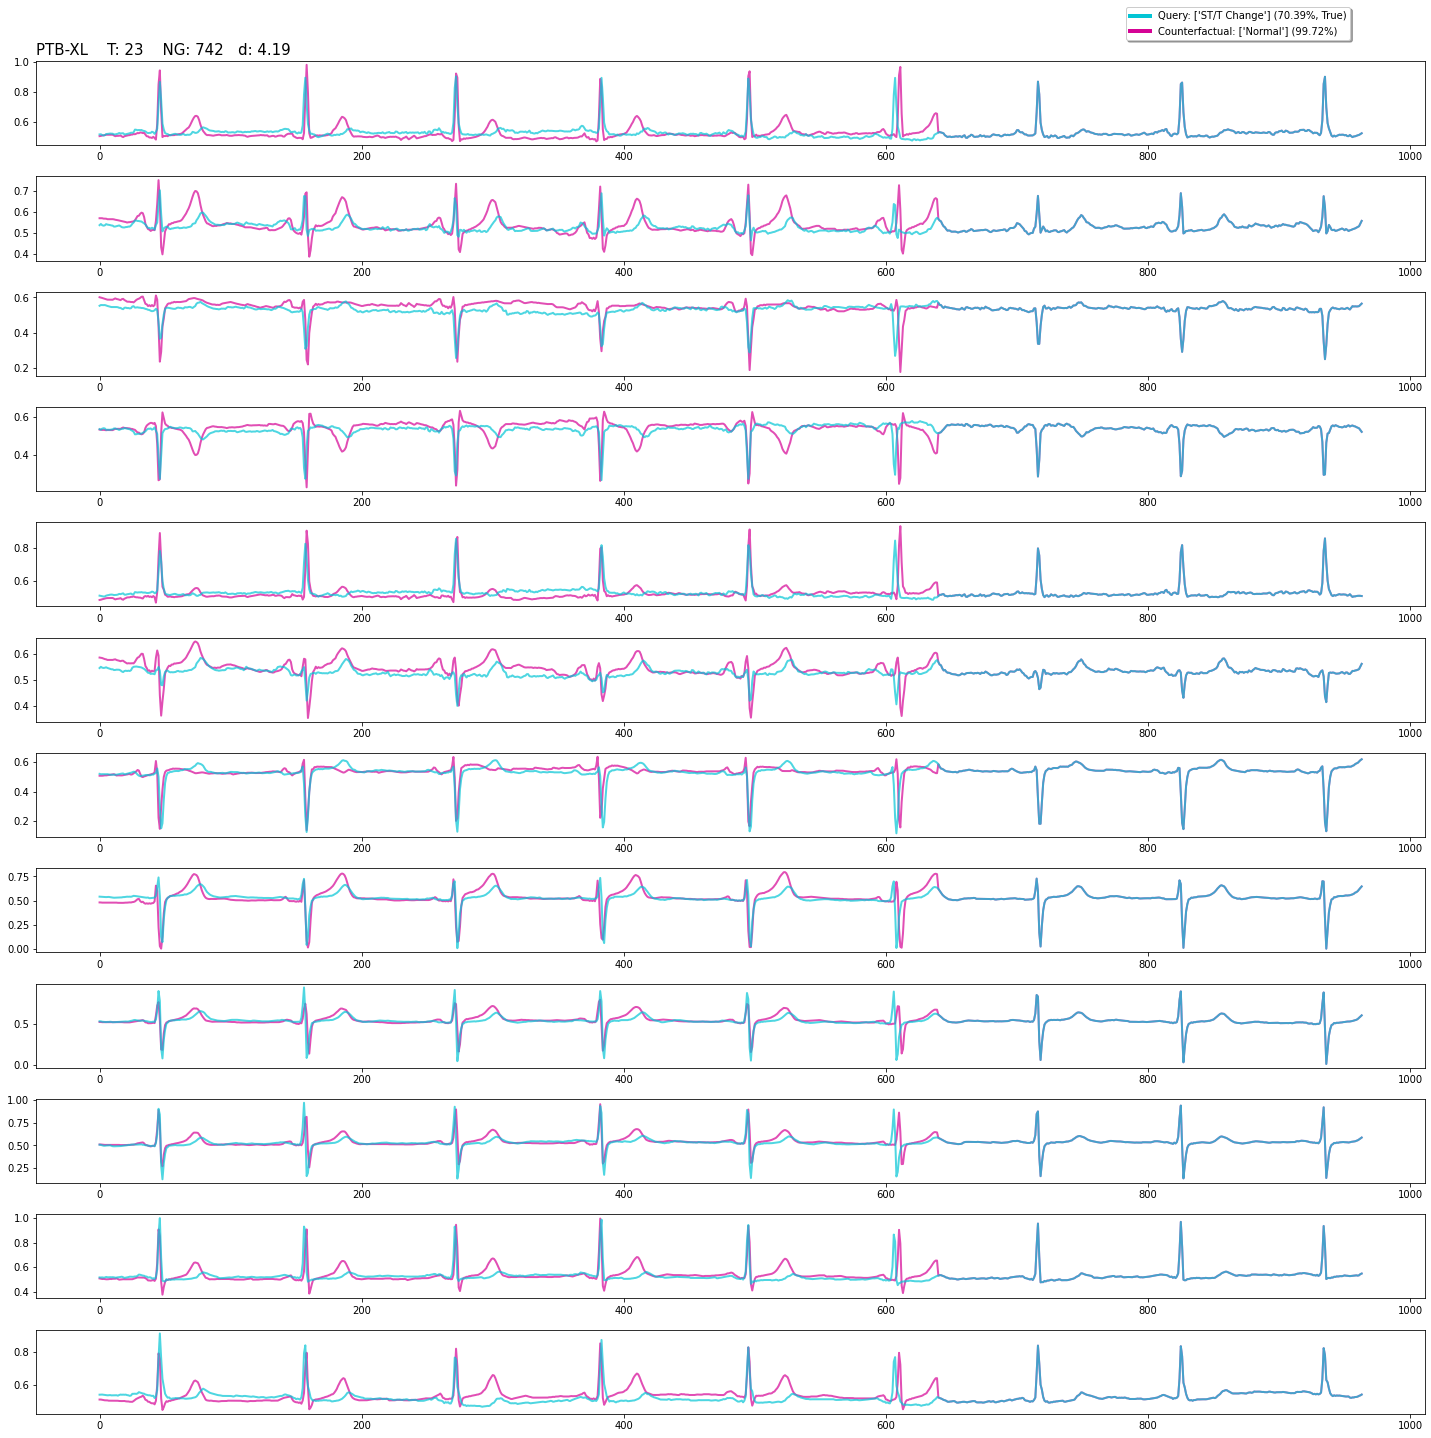

In [63]:
# Get data for PTB-XL.
dataset = "PTB-XL"
path = Path("Data") / "PTB-XL" / "cleaned_data"
X_train, y_train, X_test, y_test, X_val, y_val = load_datasets(path, load_validation_data=True)
# Get the random 1000 samples from training set as native guide candidates.
X_train = np.load(Path("Data") / f"{dataset}" / "random_data" / "X_train_random1000.npy")
y_train = np.load(Path("Data") / f"{dataset}" / "random_data" / "y_train_random1000.npy")
X_test = normalize_dataset(X_test)
X_train = normalize_dataset(X_train)
X_val = normalize_dataset(X_val)

print("Shapes of training, validation and testing data:")
print(y_train.shape, y_val.shape, y_test.shape)

# Initialisations.
native_guides_count = 1
leads = 12
boundary = 0.4
# Number of classes in the PTB-XL dataset.
num_classes = 5        
# Shape of samples for pytorch model, [None, 12] in case of different lengths.
input_shape = [1000, 12]
# Sampling frequency for pytorch model.
sampling_frequency = 100

# For plotting.
query_color = '#03C5D5'  # blue
counterfactual_color = '#D50395'  # pink
colors = [
    counterfactual_color,
    query_color
]

featuremap_layers = {
    "fastai_fcn_wang": "2",
    "fastai_resnet1d_wang": "3",
    "fastai_inception1d": "layers.0.sk.1"
}

# Model and featuremap_layer to use for predictions: 
# eather fastai_fcn_wang & 2, or fastai_resnet1d_wang & 3, or fastai_inception1d & layers.0.sk.1.
modelname = "fastai_fcn_wang"
featuremap_layer = featuremap_layers[modelname]

# Get indices of test set splitted for every class.
class_indices = []
for c in range(num_classes):
    class_indices.append(np.where(np.argmax(y_test, axis=1) == c)[0])

# Get the model.
model, fastaimodel = get_pytorch_model(modelname)
torchmodel = model

# If specific class needs to be tested.
if class_index is not None:
    X_test = X_test[class_indices[class_index]]
    y_test = y_test[class_indices[class_index]]

if X_test_index is None:
    # If no index provided take random one.
    random_indices = np.random.choice(len(y_test), 1, replace=False)
    X_test_index = random_indices[0]
y_test = y_test[X_test_index]
X_test = X_test[X_test_index].reshape(1, 1000, 12)

print("X_test_index: ", X_test_index)

# Get predicted values for data.
y_train_preds = predict(fastaimodel, X_train)
y_test_preds = predict(fastaimodel, X_test)[0]
y_test_labels = np.copy(y_test_preds)
y_ng_labels = np.copy(y_train_preds)

for y in range(len(y_test_labels)):
    if y_test_labels[y] > 0.5:
        y_test_labels[y] = 1
    else: 
        y_test_labels[y] = 0
for y in range(len(y_ng_labels)):
    for i in range(len(y_ng_labels[y])):
        if y_ng_labels[y, i] > 0.5: 
            y_ng_labels[y, i] = 1
        else: 
            y_ng_labels[y, i] = 0
y_test_labels = y_test_labels.astype(int)
y_ng_labels = y_ng_labels.astype(int)

print("query prediction:", y_test_preds)
print("query class: ", y_test)

# Get the native guide from the training set.
nuns = []
dists = []
instance = 0
out_dist, out_nuns = native_guide_retrieval(X_train, y_train, instance, X_test[instance], 
                                            y_train_preds, y_ng_labels, y_test_preds, y_test_labels,
                                            'dtw', native_guides_count, 3, boundary,
                                            save_dtwplot = False)
nun = out_nuns[0]
X_native_guide = X_train[nun]
y_native_guide = y_train[nun]

# Synchronization of the query and native guide.
old_native_guide = X_native_guide
ts1, ts2, new_len = synchronize_series(X_test[0].reshape(1000, 12),
                                       X_native_guide.reshape(1000, 12),
                                       12, 1000, show=True)
new_ts_stay, new_ts_change, new_len, median_wavelength_stay, changed_indices = wavelength_sync(ts1, ts2, 12, new_len)
new_ts_stay, new_ts_change, new_len = synchronize_series(new_ts_stay.reshape(len(new_ts_stay), 12),
                                                         new_ts_change.reshape(len(new_ts_change), 12), 
                                                         12, new_len, median_wavelength_stay, True)

print("New length of ECGs after sync:", new_len)
assert(new_len == len(new_ts_stay))
assert(new_len == len(new_ts_change))
X_test = new_ts_stay.reshape(1, len(new_ts_stay), 12)
X_native_guide = new_ts_change.reshape(1, len(new_ts_change), 12)

# Predict new synchronized native guide.
pred_old_native_guide = predict(fastaimodel, old_native_guide.reshape(1, 1000, 12))[0]
pred_native_guide = predict(fastaimodel, X_native_guide)[0]
pred_labels_native_guide = np.copy(pred_native_guide)
for y in range(len(pred_labels_native_guide)):
    if pred_labels_native_guide[y] > 0.5:
        pred_labels_native_guide[y] = 1
    else:
        pred_labels_native_guide[y] = 0
pred_labels_native_guide = pred_labels_native_guide.astype(int)

print("Native Guide index: ", nun)
print("Native guide class: ", y_native_guide)
print("Native Guide prediction before sync:", pred_old_native_guide)
print("Native Guide prediction after sync", pred_native_guide)
assert np.argmax(predict(fastaimodel, old_native_guide.reshape(1, 1000, 12)), axis=1) == np.argmax(predict(fastaimodel, X_native_guide), axis=1)

# Get the importance weights for each data point from class activation mapping.
native_guides_weights = get_cam_weights(X_native_guide, y_native_guide, new_len, 
                                        leads, modelname, featuremap_layer, pred_native_guide, pred_labels_native_guide)
assert len(native_guides_weights) == len(new_ts_change)

# Generate the counterfactual.
generated_cf, subarray_length, prob_target = counterfactual_generator_swap(X_test=X_test,
                                                                           X_test_index=0,
                                                                           native_guide=X_native_guide,
                                                                           native_guides_weights=native_guides_weights,
                                                                           instance=0,
                                                                           nun=nun,
                                                                           subarray_length=200,
                                                                           array_length=X_native_guide.shape[1],
                                                                           leads=leads,
                                                                           boundary=boundary)

# Confidence values.
query_pred_confidence = np.mean(y_test_preds[y_test_preds>0.5])
cf_pred = predict(fastaimodel, generated_cf.reshape(1, len(generated_cf),leads))[0]
cf_pred = np.array(cf_pred)
cf_confidence = np.mean(cf_pred[cf_pred > 0.5])
y_cf_labels = np.copy(cf_pred)
for y in range(len(y_cf_labels)):
    if y_cf_labels[y] > 0.5: 
        y_cf_labels[y] = 1
    else: 
        y_cf_labels[y] = 0
print("New confidence: ",  cf_confidence)

# Plot the counterfactual.
dfs = []
fig, ax = plt.subplots(leads, 1, figsize=(20, 20))
for lead in range(leads):
    # Input query and counterfactual data.
    dfs.append(pd.DataFrame({
        "Counterfactual": list(generated_cf[:,lead].flatten()),
        "Query": list(X_test[0,:,lead].flatten())
    }))
    plot = dfs[lead].plot(linewidth=2, color=colors, ax=ax[lead], alpha=0.7)
    # Remove the individual plot legends to put them to another position.
    plot.legend_.remove()

title = (f"{dataset}    T: {X_test_index}    NG: {nun}   d: {round(out_dist[0],2)}")
ax[0].set_title(title, fontsize=15, loc="left")
# Why not reuse the `colors` list from above?
custom_lines = [Line2D([0], [0], color=query_color, lw=4), Line2D([0], [0], color=counterfactual_color, lw=4), Line2D([0], [0], color='#F5D300', lw=4)]
ax[0].legend(custom_lines, [f'Query: {ptb_xl_labelname(y_test_labels)} ({round(query_pred_confidence*100,2)}%, {(y_test_labels == (y_test)).all()})',
                            f'Counterfactual: {(ptb_xl_labelname(y_cf_labels))} ({round(cf_confidence*100,2)}%)'
                            ],  loc='upper right', bbox_to_anchor=(0.95, 1.7), fancybox=True, shadow=True)
plt.tight_layout()
plt.savefig(f'plot_counterfactuals/'+ str(dataset)  + f'test{X_test_index}_ng{nun}')
plt.show()